<a href="https://colab.research.google.com/github/Takumi173/JPMA2023TF1-1/blob/main/JPMA2023_case1_(2)_%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E5%89%8D%E5%87%A6%E7%90%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 前準備

## Google Driveの接続とパスの指定

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# 拡張データの保存先ディレクトリの指定
datadir = '/content/drive/MyDrive/JPMA2023_case1/'

Mounted at /content/drive


## ライブラリとパッケージのインストール

In [2]:
!pip install mecab-python3 fugashi
!pip install jaconv neologdn

import jaconv
import unicodedata
import neologdn
import re
import MeCab
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.6/144.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jaconv: filename=jaconv-0.3.4-py3-none-any.whl size=16416 sha256=513c99361231266cf627626f06292f57297a721844a6082bcef199b400352f0d
  Stored in directory: /root/.cache/pip/wheels/46/8f/2e/a730bf1fca05b33e532d5d91dabdf406c9b718ec85b01b1b54
  Created wheel for neologdn: filename=neologdn-0.5.3-cp310-cp310-linux_x86_64.whl size=223869 sha256=ef74ee7aae966b92aa954cb8f7751b5e23993c4a491e468a5cc56f5757880ea5
  Stored in directory: /root/.cache/pip/wheels/f3/06/cd/3216b1007983e3cde801f6376c641617c37f4f520f9faed644
Successfully built jaconv neologdn


## MeCabの設定

In [3]:
# MeCabとNEologdの設定
!apt install mecab libmecab-dev mecab-ipadic-utf8 file
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -a -y

# 環境変数でmecabrcの場所を指定
import os
os.environ['MECABRC'] = "/etc/mecabrc"

# NEologdの展開場所を取得
import subprocess
cmd = 'echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
neologd_dic_dir_path = subprocess.check_output(cmd, shell=True).decode('utf-8').strip()

# 万病辞書のダウンロードと設定
!wget http://sociocom.jp/~data/2018-manbyo/data/MANBYO_201907_Dic-utf8.dic
manbyo_dic_path = 'MANBYO_201907_Dic-utf8.dic'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
file is already the newest version (1:5.41-3ubuntu0.1).
The following additional packages will be installed:
  libmecab2 mecab-ipadic mecab-utils
The following NEW packages will be installed:
  libmecab-dev libmecab2 mecab mecab-ipadic mecab-ipadic-utf8 mecab-utils
0 upgraded, 6 newly installed, 0 to remove and 45 not upgraded.
Need to get 7,367 kB of archives.
After this operation, 59.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab2 amd64 0.996-14build9 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab-dev amd64 0.996-14build9 [306 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-utils amd64 0.996-14build9 [4,850 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-ipadic all 2.7.0-20070801+main-3 [6,718 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 mecab amd6

## データの読み込み

In [4]:
# Test Dataのパス
Data_Test = 'https://github.com/Takumi173/JPMA2023TF1-1/releases/download/20240529/Case1_Test_data.tsv'

# Training Dataのパス（拡張済みデータを指定）
Data_Train = datadir + 'combined_training_data_(Seed_56789).tsv'

# 前処理関数の定義

In [5]:
# MeCab辞書にNEologdと万病辞書を指定
tagger = MeCab.Tagger("-d " + neologd_dic_dir_path + " -u " + manbyo_dic_path)

# MeCabによる分かち書き＆原形変換関数を定義
def genkei(text):
  words = []
  for c in tagger.parse(text).splitlines()[:-1]:
    # surfaceに単語、featureに解析結果を格納
    # 対象が存在しない場合は無視して次へ
    try:
        surface, feature = c.split('\t')
    except:
        continue

    # 解析結果から品詞と原形を取得
    hinshi = feature.split(',')[0]
    genkei = feature.split(',')[6]

    # 原形が定義されている場合は単語を原形に置き換え
    if feature.split(',')[-1].isdigit() == False and genkei != '*':
      surface = genkei

    # 残す品詞を定義
    #if hinshi in ['名詞','形容詞','助動詞', '動詞'] and surface != '*':
    if hinshi != '記号' and surface != '*': # 品詞を絞り込まない場合
      words.append(surface)
    else:
      continue

  return ' '.join(words)

# 文字の正規化後に上記関数を実行する事前処理関数を定義
def preprocess(text):
  text = jaconv.normalize(text, "NFKC")
  text = unicodedata.normalize("NFKC", text)
  text = neologdn.normalize(text)

  text = re.sub(r'。$', '', text)   # 文末の。を削除
  #text = re.sub(r'\d+', '0', text)  # 連続する数値を0に置換

  text = genkei(text)
  return text

# 前処理の実行

## Test Data

### 前処理関数の実行

In [6]:
# 処理対象データをDataFrameに格納
Texts = pd.read_table(Data_Test)

# 対象のラベルと事前処理を実行したカラムを追加して保存
Texts['ICD10_Term_WAKATI'] = Texts['TEST_DATA'].apply(preprocess)
Texts.to_csv(datadir + 'Test_Data_Wakati_all.tsv', sep='\t', index=False)

# 処理結果の確認
Texts

,ICD10_CATEGORY,ICD-10 Code,ICD-10 Term,TEST_DATA,INITIAL,ICD10_Term_WAKATI
0,A00,A00.0,コレラ菌によるコレラ,コレラ（コレラ菌による）,YI,コレラ コレラ 菌 による
1,A01,A01.1,パラチフスA,パラチフスa,YI,パラチフス a
2,A02,A02.0,サルモネラ腸炎,腸炎 サルモネラ感染,YI,腸炎 サルモネラ感染
3,A03,A03.0,志賀菌による細菌性赤痢,細菌（志賀菌）赤痢,YI,細菌 志賀 菌 赤痢
4,A04,A04.5,カンピロバクター腸炎,カンピロバクター腸炎による腹痛、下痢、嘔吐,YI,カンピロバクター腸炎 による 腹痛 下痢 嘔吐
...,...,...,...,...,...,...
1524,X95,X95.X0,その他及び詳細不明の銃器の発射による加害にもとづく傷害及び死亡；家（庭）,家でその他の銃器の発射による加害にもとづく傷害及び死亡,DH_231127,家 で その他 の 銃器 の 発射 による 加害 に もとづく 傷害 及ぶ 死亡
1525,X96,X96.X0,爆発物による加害にもとづく傷害及び死亡；家（庭）,家で爆発物による加害にもとづく傷害及び死亡,DH_231127,家 だ 爆発 物 による 加害 に もとづく 傷害 及ぶ 死亡
1526,X97,X97.X0,煙，火及び火炎による加害にもとづく傷害及び死亡；家（庭）,家で煙，火及び火炎による加害にもとづく傷害及び死亡,DH_231127,家出 煙 火 及び 火炎 による 加害 に もとづく 傷害 及ぶ 死亡
1527,X98,X98.X0,スチーム，高温蒸気及び高温物体による加害にもとづく傷害及び死亡；家（庭）,家でスチーム，高温蒸気及び高温物体による加害にもとづく傷害及び死亡,DH_231127,家出 スチーム 高温 蒸気 及び 高温 物体 による 加害 に もとづく 傷害 及ぶ 死亡


## Training Data

### 前処理関数の実行

In [7]:
# Training dataの取得
Texts = pd.read_table(Data_Train)

# 対象のラベルと事前処理を実行したカラムを追加
Texts['ICD10_Term_WAKATI'] = Texts['ICD10_Term'].apply(preprocess)

# 処理結果の確認
Texts

,ICD10_CATEGORY,ICD10_CATEGORY_TERM,ICD10_Code,ICD10_Term,FOR_USAGE,ICD10_Term_WAKATI
0,A00,コレラ,A00.0,コレラ菌によるコレラ,train,コレラ 菌 による コレラ
1,A00,コレラ,A00.1,エルトールコレラ菌によるコレラ,train,エルトールコレラ 菌 による コレラ
2,A00,コレラ,A00.9,コレラ，詳細不明,train,コレラ 詳細不明
3,A01,腸チフス及びパラチフス,A01.0,腸チフス,train,腸チフス
4,A01,腸チフス及びパラチフス,A01.1,パラチフスA,train,パラチフス A
...,...,...,...,...,...,...
147401,X99,鋭利な物体による加害にもとづく傷害及び死亡,X99.X5,鋭利な物体による傷害による死傷者；商業・サービス施設,train,鋭利 だ 物体 による 傷害 による 死傷 者 商業 サービス 施設
147402,X99,鋭利な物体による加害にもとづく傷害及び死亡,X99.X6,鋭利な物体による傷害による死傷者；工業地域および建設現場,train,鋭利 だ 物体 による 傷害 による 死傷 者 工業地域 お呼び 建設現場
147403,X99,鋭利な物体による加害にもとづく傷害及び死亡,X99.X7,鋭利な物体による傷害による死傷者；農場,train,鋭利 だ 物体 による 傷害 による 死傷 者 農場
147404,X99,鋭利な物体による加害にもとづく傷害及び死亡,X99.X8,鋭利な物体による負傷による死傷者；その他の指定場所,train,鋭利 だ 物体 による 負傷 による 死傷 者 その他 の 指定 場所


### 重複データの削除

In [8]:
data_name = "ICD10_Term_WAKATI"
label_name = "ICD10_CATEGORY"
label_id = "Label"

print('RAW Shape : ' + str(Texts.shape))
Texts = Texts[[data_name, label_name]].drop_duplicates()
print('Drup dups : ' + str(Texts.shape))
Texts

RAW Shape : (147406, 6)
Drup dups : (134106, 2)


,ICD10_Term_WAKATI,ICD10_CATEGORY
0,コレラ 菌 による コレラ,A00
1,エルトールコレラ 菌 による コレラ,A00
2,コレラ 詳細不明,A00
3,腸チフス,A01
4,パラチフス A,A01
...,...,...
147401,鋭利 だ 物体 による 傷害 による 死傷 者 商業 サービス 施設,X99
147402,鋭利 だ 物体 による 傷害 による 死傷 者 工業地域 お呼び 建設現場,X99
147403,鋭利 だ 物体 による 傷害 による 死傷 者 農場,X99
147404,鋭利 だ 物体 による 負傷 による 死傷 者 その他 の 指定 場所,X99


### 同一Termが異なるカテゴリにラベリングされているデータの除外

In [9]:
_df = Texts.groupby(data_name)[label_name].agg(['count', lambda x: ', '.join(map(str, x))]).reset_index()
_df.columns = [data_name, 'Count', label_name]


Target_df = _df[_df['Count'] == 1]
print('*** １つのカテゴリにのみ割り当てられているTerms → Trainingデータとする ***')
display(Target_df)


Exclude_df = _df[_df['Count'] > 1]
print('\n\n*** 複数のカテゴリにのみ割り当てられているTerms → Trainingデータから除外 ***')
display(Exclude_df)

*** １つのカテゴリにのみ割り当てられているTerms → Trainingデータとする ***


,ICD10_Term_WAKATI,Count,ICD10_CATEGORY
0,#地震 に ヨル その他 の 明示 為る れる タエイキョウ の 受傷 者 イエニワ,1,X34
1,#地震 に ヨル その他 ノメージ する れる タ 影響 の 受傷 射~Sya~ 工業 用 ...,1,X34
2,#地震 に ヨル 詳細不明 の エイキョウノジュショウシャ スポーツ 施設 及び 競技 シセツ,1,X34
3,#地震 に 因る ソノ 他 ノメージ 為る レ た 影響 の ジュショーシャ ソノ 他 の ...,1,X34
4,#地震 に 因る ソノタノメイジ さ レルタエーキョーノジュショウシャ ショウギョウ 及び ...,1,X34
...,...,...,...
132569,鼻骨骨折 開放性 が 悪化,1,S02
132570,鼻骨骨折 開放性 で,1,S02
132571,鼻骨骨折 開放性 により,1,S02
132572,鼻骨骨折 開放性 の ため,1,S02




*** 複数のカテゴリにのみ割り当てられているTerms → Trainingデータから除外 ***


,ICD10_Term_WAKATI,Count,ICD10_CATEGORY
1124,S 状 て 結腸,2,"C18, D12"
1126,S 状 結腸,2,"C18, D12"
1127,S 状 結腸 から,2,"C18, D12"
1128,S 状 結腸 が 悪化,2,"C18, D12"
1129,S 状 結腸 で,2,"C18, D12"
...,...,...,...
130561,髄膜 部位 不明 が 悪化,3,"C70, D32, D42"
130562,髄膜 部位 不明 だ,3,"C70, D32, D42"
130563,髄膜 部位 不明 により,3,"C70, D32, D42"
130564,髄膜 部位 不明 の ため,3,"C70, D32, D42"


### 2レコード以下のカテゴリはモデル構築ができないため除外

In [10]:
group_counts = Target_df.groupby(label_name).size()
invalid_groups = group_counts[group_counts <= 2 ].index
invalid_records = Target_df[Target_df[label_name].isin(invalid_groups)]

print('*** クラスのレコード数２以下のレコード → 除外 ***')
display(invalid_records)

valid_groups = group_counts[group_counts > 2 ].index
Target_df = Target_df[Target_df[label_name].isin(valid_groups)]

print('\n\n*** クラスのレコード数３以上のレコード → Training dataとして維持 ***')
Target_df_sorted = Target_df.sort_values(by=label_name).reset_index(drop=True)
Target_df_sorted

*** クラスのレコード数２以下のレコード → 除外 ***


,ICD10_Term_WAKATI,Count,ICD10_CATEGORY
44726,ノウズイマク,1,D42
130546,髄膜 ブイフメイ,1,D42




*** クラスのレコード数３以上のレコード → Training dataとして維持 ***


,ICD10_Term_WAKATI,Count,ICD10_CATEGORY
0,いつも の コレラ 菌 による コレラ,1,A00
1,コレラ 詳細不明 の 悪化,1,A00
2,エルトールコレラ 菌 による コレラ から,1,A00
3,コレラ よる に 菌 エルトールコレラ,1,A00
4,不明 詳細 コレラ,1,A00
...,...,...,...
131396,鋭利 だ 物体 による 加害 に もとづく 傷害 及ぶ 死亡 工業 用 地域 及び 建築現場 で,1,X99
131397,鋭利 だ 物体 による 加害 に もとづく 傷害 及ぶ 死亡 工業 用 地域 及び 建築現場...,1,X99
131398,鋭利 だ 物体 による 加害 に もとづく 傷害 及ぶ 死亡 工業 用 地域 及び 建築現場...,1,X99
131399,鋭利 だ 物体 による 加害 に もとづく 傷害 及ぶ 死亡 居住施設 から,1,X99


### Training dataの分布確認

***学習データのカテゴリごとのレコード数（平均）***
平均: 86.108125819135

***学習データのカテゴリごとのレコード数（中央値）***
中央値: 79.0

***学習データのカテゴリごとのレコード数（表）***


,ICD10_CATEGORY,count
1462,X34,571
341,F15,520
1161,S02,385
1193,S36,384
1238,S82,382
...,...,...
231,D30,4
233,D32,3
240,D40,3
241,D41,3



***学習データのカテゴリごとのレコード数（グラフ）***


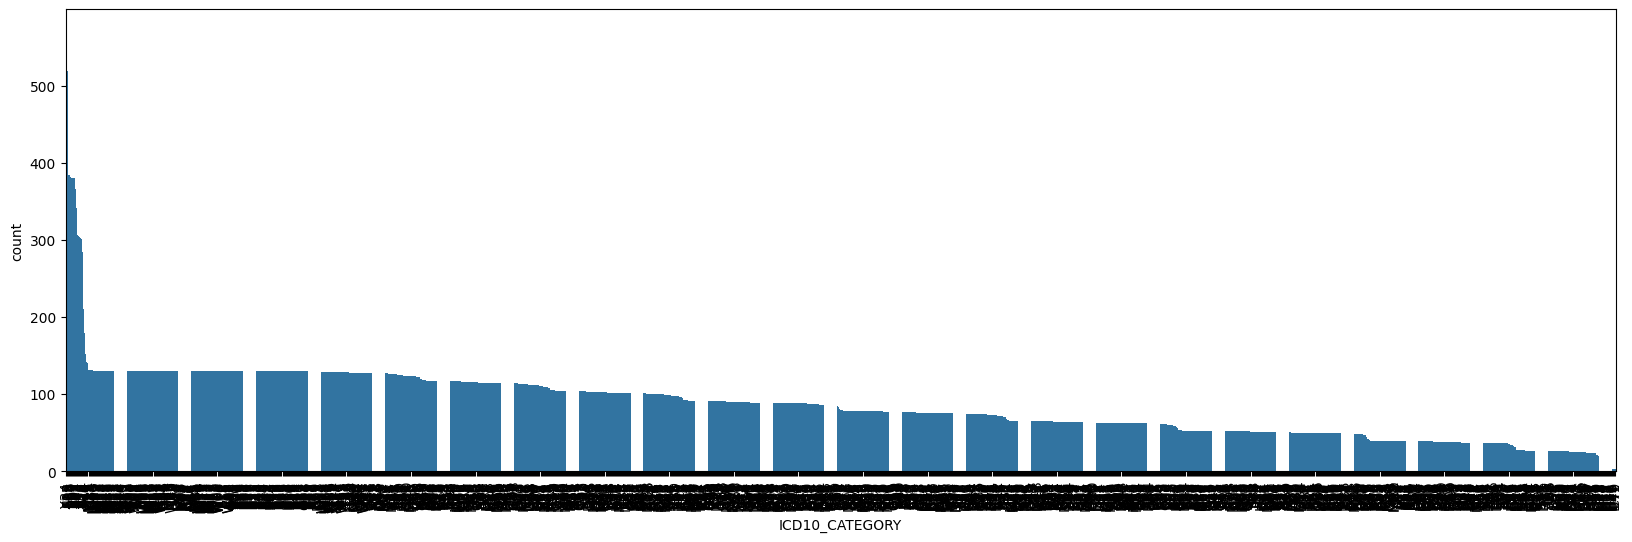

,ICD10_CATEGORY,count
1123,R44,59
176,C60,59
1132,R57,59
471,H34,58
1,A01,56
...,...,...
231,D30,4
233,D32,3
240,D40,3
241,D41,3



***カテゴリの学習データが60レコード未満のカテゴリ（表）***

***カテゴリの学習データが60レコード未満のカテゴリ（グラフ）***


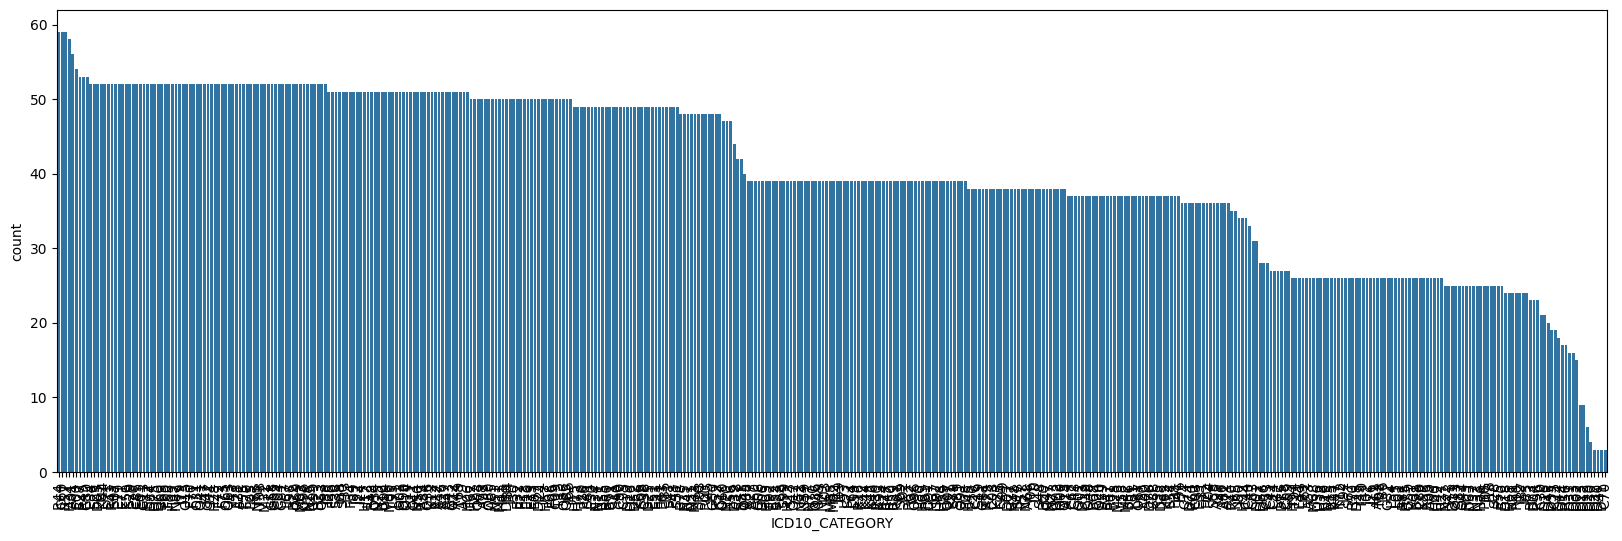

In [11]:
grouped_data = Target_df_sorted.groupby(label_name).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)

# カラムの平均を求める
mean_value = grouped_data['count'].mean()
print('***学習データのカテゴリごとのレコード数（平均）***')
print(f'平均: {mean_value}')

# カラムの中央値を求める
median_value = grouped_data['count'].median()
print('\n***学習データのカテゴリごとのレコード数（中央値）***')
print(f'中央値: {median_value}')


print('\n***学習データのカテゴリごとのレコード数（表）***')
display(grouped_data)

print('\n***学習データのカテゴリごとのレコード数（グラフ）***')
plt.figure(figsize=(20, 6))
plt.xticks(rotation='vertical')
sns.barplot(x=label_name, y='count', data=grouped_data)
plt.show()

print('\n***カテゴリの学習データが60レコード未満のカテゴリ（表）***')
display(grouped_data[grouped_data['count'] < 60])

print('\n***カテゴリの学習データが60レコード未満のカテゴリ（グラフ）***')
plt.figure(figsize=(20, 6))
plt.xticks(rotation='vertical')
sns.barplot(x=label_name, y='count', data=grouped_data[grouped_data['count'] < 60])
plt.show()

### カテゴリに連番を付与

In [12]:
# カテゴリに連番を付与
# ラベルが0から連番にならないとTrainerでdevice-side assert triggeredが発生するので要注意。
Target_df_sorted[label_id] = pd.factorize(Target_df_sorted[label_name])[0]

# 置き換え用の辞書を作成
df_dict = Target_df_sorted[[label_id, label_name]].drop_duplicates()
id_dict = dict(zip(df_dict[label_id], df_dict[label_name]))
print(id_dict)
print(len(id_dict))

Target_df_sorted

{0: 'A00', 1: 'A01', 2: 'A02', 3: 'A03', 4: 'A04', 5: 'A05', 6: 'A06', 7: 'A07', 8: 'A08', 9: 'A09', 10: 'A15', 11: 'A16', 12: 'A17', 13: 'A18', 14: 'A19', 15: 'A20', 16: 'A21', 17: 'A22', 18: 'A23', 19: 'A24', 20: 'A25', 21: 'A26', 22: 'A27', 23: 'A28', 24: 'A30', 25: 'A31', 26: 'A32', 27: 'A36', 28: 'A37', 29: 'A39', 30: 'A40', 31: 'A41', 32: 'A42', 33: 'A43', 34: 'A44', 35: 'A48', 36: 'A49', 37: 'A50', 38: 'A51', 39: 'A52', 40: 'A53', 41: 'A54', 42: 'A56', 43: 'A59', 44: 'A60', 45: 'A63', 46: 'A66', 47: 'A67', 48: 'A68', 49: 'A69', 50: 'A71', 51: 'A74', 52: 'A75', 53: 'A77', 54: 'A79', 55: 'A80', 56: 'A81', 57: 'A82', 58: 'A83', 59: 'A84', 60: 'A85', 61: 'A87', 62: 'A88', 63: 'A92', 64: 'A93', 65: 'A95', 66: 'A96', 67: 'A98', 68: 'B00', 69: 'B01', 70: 'B02', 71: 'B05', 72: 'B06', 73: 'B08', 74: 'B15', 75: 'B16', 76: 'B17', 77: 'B18', 78: 'B19', 79: 'B20', 80: 'B21', 81: 'B22', 82: 'B23', 83: 'B25', 84: 'B26', 85: 'B27', 86: 'B30', 87: 'B33', 88: 'B34', 89: 'B35', 90: 'B36', 91: 'B37

,ICD10_Term_WAKATI,Count,ICD10_CATEGORY,Label
0,いつも の コレラ 菌 による コレラ,1,A00,0
1,コレラ 詳細不明 の 悪化,1,A00,0
2,エルトールコレラ 菌 による コレラ から,1,A00,0
3,コレラ よる に 菌 エルトールコレラ,1,A00,0
4,不明 詳細 コレラ,1,A00,0
...,...,...,...,...
131396,鋭利 だ 物体 による 加害 に もとづく 傷害 及ぶ 死亡 工業 用 地域 及び 建築現場 で,1,X99,1525
131397,鋭利 だ 物体 による 加害 に もとづく 傷害 及ぶ 死亡 工業 用 地域 及び 建築現場...,1,X99,1525
131398,鋭利 だ 物体 による 加害 に もとづく 傷害 及ぶ 死亡 工業 用 地域 及び 建築現場...,1,X99,1525
131399,鋭利 だ 物体 による 加害 に もとづく 傷害 及ぶ 死亡 居住施設 から,1,X99,1525


In [13]:
# 前処理結果の保存
Target_df_sorted.to_csv(datadir + 'combined_training_data_watati_all.tsv', sep='\t', index=False)

# 置き換え用辞書の保存
with open(datadir+'id_dict.pkl', 'wb') as file:
    pickle.dump(id_dict, file)